# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-04-05 11:06:49,006 fedbiomed INFO - Component environment:
2022-04-05 11:06:49,009 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-04-05 11:06:50,677 fedbiomed INFO - Messaging researcher_5708e13b-6162-4968-92f5-91194c4e35ad successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x107899520>
2022-04-05 11:06:50,706 fedbiomed INFO - Listing available datasets in all nodes... 
2022-04-05 11:06:50,716 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
2022-04-05 11:06:50,741 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
2022-04-05 11:06:50,747 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'resea

{'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [16954, 3, 64, 64]}],
 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}],
 'node_f1a53932-5289-435d-90fe-9bc12737b4b5': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List
from opacus.validators import ModuleValidator
#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
        
        if (('DP' in model_args) and (model_args['DP']==True)):
            self.validate_and_fix_model()
            
        #self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-5)

    def validate_and_fix_model(self):
        # Validate and Fix model to be DP-compliant
        if not ModuleValidator.is_valid(self.model):
            print('######################################## Fixing Model ########################################')
            self.model = ModuleValidator.fix(self.model)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
model_args = {'use_gpu': True}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['mednist']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-05 11:07:18,928 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/05/2022 11:07:18:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-05 11:07:18,992 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 11:07:18:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
2022-04-05 11:07:19,000 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 11:07:19:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-04-05 11:07:30,744 fedbiomed INFO - Sampled nodes in round 0 ['node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18']
04/05/2022 11:07:30:INFO:Sampled nodes in round 0 ['node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18']
2022-04-05 11:07:30,749 fedbiomed INFO - Send message to node node_f1a53932-5289-435d-90fe-9bc12737b4b5 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4

04/05/2022 11:07:31:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_init_0e1dbabf-c5e4-42d8-a779-cb20e9fcef96.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
2022-04-05 11:07:31,084 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe54

04/05/2022 11:11:13:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=80 Loss:1.8817968368530273
2022-04-05 11:11:22,404 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [2000/18000 (9%)]	Loss: 1.807442
04/05/2022 11:11:22:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [2000/18000 (9%)]	Loss: 1.807442
2022-04-05 11:11:22,422 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=80 Loss:1.8074415922164917
04/05/2022 11:11:22:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=80 Loss:1.8074415922164917
2022-04-05 11:11:51,679 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [1800/18000 (10%)]	Loss: 1.807033
04/05/2022 11:11:51:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [1800/18000 (10%)]	Loss: 1.807033
2022-04-05 11:11:51,685 fed

2022-04-05 11:16:16,990 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=130 Loss:1.8219393491744995
04/05/2022 11:16:16:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=130 Loss:1.8219393491744995
2022-04-05 11:16:24,257 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [2210/18000 (14%)]	Loss: 1.854519
04/05/2022 11:16:24:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [2210/18000 (14%)]	Loss: 1.854519
2022-04-05 11:16:24,262 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=130 Loss:1.8545193672180176
04/05/2022 11:16:24:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=130 Loss:1.8545193672180176
2022-04-05 11:16:49,951 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [3500/18000 (16%)]	Loss: 1.765522
04/05/2022 

04/05/2022 11:20:46:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [3600/16954 (21%)]	Loss: 1.736730
2022-04-05 11:20:46,423 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=180 Loss:1.7367298603057861
04/05/2022 11:20:46:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=180 Loss:1.7367298603057861
2022-04-05 11:20:51,891 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [3960/18000 (20%)]	Loss: 1.830621
04/05/2022 11:20:51:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [3960/18000 (20%)]	Loss: 1.830621
2022-04-05 11:20:51,894 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=180 Loss:1.8306210041046143
04/05/2022 11:20:51:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=180 Loss:1.8306210041046143
2022-04-05 11:21:30,433 fed

2022-04-05 11:25:22,881 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [4140/16954 (27%)]	Loss: 1.721989
04/05/2022 11:25:22:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [4140/16954 (27%)]	Loss: 1.721989
2022-04-05 11:25:22,885 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=230 Loss:1.7219892740249634
04/05/2022 11:25:22:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=230 Loss:1.7219892740249634
2022-04-05 11:25:48,885 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [5980/18000 (26%)]	Loss: 1.854204
04/05/2022 11:25:48:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [5980/18000 (26%)]	Loss: 1.854204
2022-04-05 11:25:48,889 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=230 Loss:1.8542042970657349
04/05/

04/05/2022 11:27:06:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - model.postprocess() method not provided
2022-04-05 11:27:07,772 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1398b72b0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
04/05/2022 11:27:07:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1398b72b0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test

04/05/2022 11:27:26:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.094382
2022-04-05 11:27:26,184 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=10 Loss:0.09438242763280869
04/05/2022 11:27:26:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=10 Loss:0.09438242763280869
2022-04-05 11:27:34,608 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [170/1000 (16%)]	Loss: 0.068719
04/05/2022 11:27:34:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [170/1000 (16%)]	Loss: 0.068719
2022-04-05 11:27:34,621 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.06871949881315231
04/05/2022 11:27:34:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.06871949881315231
2022-04-05 11:27:37,622 fedbiomed

2022-04-05 11:27:59,205 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=False, gpu_num=None)
04/05/2022 11:27:59:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=False, gpu_num=None)
2022-04-05 11:27:59,423 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [570/1000 (48%)]	Loss: 0.091158
04/05/2022 11:27:59:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [570/1000 (48%)]	Loss: 0.091158
2022-04-05 11:27:59,438 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=30 Loss:0.09115836769342422
04/05/2022 11:27:59:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=30 Loss:0.09115836769342422
2022-04-05 11:28:00,860 fedbiomed 

2022-04-05 11:28:47,101 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [170/1000 (16%)]	Loss: 0.065899
04/05/2022 11:28:47:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [170/1000 (16%)]	Loss: 0.065899
2022-04-05 11:28:47,109 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=10 Loss:0.06589898467063904
04/05/2022 11:28:47:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=10 Loss:0.06589898467063904
2022-04-05 11:28:50,758 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [800/1000 (63%)]	Loss: 0.085960
04/05/2022 11:28:50:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [800/1000 (63%)]	Loss: 0.085960
2022-04-05 11:28:50,763 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=40 Loss:0.08595959097146988
04/05/2022 11:

04/05/2022 11:29:39:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=60 Loss:0.08009952306747437
2022-04-05 11:29:39,851 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.079258
04/05/2022 11:29:39:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.079258
2022-04-05 11:29:39,853 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.07925837486982346
04/05/2022 11:29:39:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.07925837486982346
2022-04-05 11:29:43,264 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.066050
04/05/2022 11:29:43:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.066050
2022-04-05 11:29:43,278 fedbio

2022-04-05 11:30:26,863 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.07610935717821121
04/05/2022 11:30:26:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.07610935717821121
2022-04-05 11:30:29,154 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [760/1000 (63%)]	Loss: 0.071025
04/05/2022 11:30:29:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [760/1000 (63%)]	Loss: 0.071025
2022-04-05 11:30:29,157 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=40 Loss:0.07102527469396591
04/05/2022 11:30:29:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=40 Loss:0.07102527469396591
2022-04-05 11:30:31,980 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [600/1000 (63%)]	Loss: 0.063535
04/05/2022 11:30:31

2022-04-05 11:30:55,560 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
04/05/2022 11:30:55:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-05 11:30:55,973 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [840/1000 (95%)]	Loss: 0.066740
04/05/2022 11:30:55:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [840/1000 (95%)]	Loss: 0.066740
2022-04-05 11:30:55,975 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.06674045324325562
04/05/2022 11:30:55:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.06674045324325562
2022-04-05 11:30:59,070 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / D

04/05/2022 11:31:06:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x138070430>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}
2022-04-05 11:31:06,314 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU, though researcher requested GPU
04/05/2022 11:31:06:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 11:31:06,320 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=Non

04/05/2022 11:31:38:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=60 Loss:0.059525296092033386
2022-04-05 11:31:40,565 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
04/05/2022 11:31:40:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
2022-04-05 11:31:40,571 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
04/05/2022 11:31:40:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
2022-04-05 11:31:41,139 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_f65a0034-ce1e-499e-a538-c5ce4a7988c1.pt successful, with status code 201
04/05/2022 11:31:41:INFO:log from: node_c250e95b-f7

04/05/2022 11:31:49:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=0 Loss:0.049016617238521576
2022-04-05 11:31:50,608 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.057936
04/05/2022 11:31:50:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.057936
2022-04-05 11:31:50,610 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=60 Loss:0.057936251163482666
04/05/2022 11:31:50:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=60 Loss:0.057936251163482666
2022-04-05 11:31:52,298 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.053975
04/05/2022 11:31:52:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.053975
2022-04-05 11:31:52,313 fedbiomed 

2022-04-05 11:32:21,233 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=50 Loss:0.06344334036111832
04/05/2022 11:32:21:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=50 Loss:0.06344334036111832
2022-04-05 11:32:22,363 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.049629
04/05/2022 11:32:22:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.049629
2022-04-05 11:32:22,376 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=50 Loss:0.049629099667072296
04/05/2022 11:32:22:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=50 Loss:0.049629099667072296
2022-04-05 11:32:25,450 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.044862
04/05/2022 11:3

04/05/2022 11:32:49:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.047409
2022-04-05 11:32:49,899 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.04740919545292854
04/05/2022 11:32:49:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.04740919545292854
2022-04-05 11:32:51,001 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.052401
04/05/2022 11:32:51:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.052401
2022-04-05 11:32:51,017 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.05240120738744736
04/05/2022 11:32:51:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.05240120738744736
2022-04-05 11:32:53,769 fedbiomed

04/05/2022 11:33:13:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.03624384105205536
2022-04-05 11:33:14,755 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - running model.postprocess() method
04/05/2022 11:33:14:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - running model.postprocess() method
2022-04-05 11:33:14,762 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - model.postprocess() method not provided
04/05/2022 11:33:14:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - model.postprocess() method not provided
2022-04-05 11:33:15,246 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_95f6134c-3f44-499f-a096-8533f5c10cf8.pt successful, with status code 201
04/05/2022 11:33:15:INFO:log from: node_4a9dde8e-bb3

04/05/2022 11:33:42:DEBUG:upload (HTTP GET request) of file node_params_54265bf5-0e34-404d-afa9-30681fd6cb5b.pt successful, with status code 200
2022-04-05 11:33:42,938 fedbiomed INFO - Nodes that successfully reply in round 0 ['node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b']
04/05/2022 11:33:42:INFO:Nodes that successfully reply in round 0 ['node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b']
2022-04-05 11:33:43,366 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_99dbab0d-6642-4d44-badd-bb798d46b4f8.pt successful, with status code 201
04/05/2022 11:33:43:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_99dbab0d-6

04/05/2022 11:33:43:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_99dbab0d-6642-4d44-badd-bb798d46b4f8.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}}
2022-04-05 11:33:43,476 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 

2022-04-05 11:33:43,512 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_99dbab0d-6642-4d44-badd-bb798d46b4f8.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}, 'training': True, 'model_args': {'use_gpu': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/05/2022 11:33:43:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18

04/05/2022 11:33:46:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 11:33:46,466 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/05/2022 11:33:46:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 11:33:46,551 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13c82d910>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'ep

04/05/2022 11:34:04:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=30 Loss:0.04456528276205063
2022-04-05 11:34:04,756 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.040810
04/05/2022 11:34:04:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.040810
2022-04-05 11:34:04,759 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=30 Loss:0.04081033915281296
04/05/2022 11:34:04:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=30 Loss:0.04081033915281296
2022-04-05 11:34:12,959 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.048697
04/05/2022 11:34:12:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.048697
2022-04-05 11:34:12,963 fedbio

2022-04-05 11:34:39,522 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=10 Loss:0.03674261271953583
04/05/2022 11:34:39:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=10 Loss:0.03674261271953583
2022-04-05 11:34:39,818 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.039214
04/05/2022 11:34:39:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.039214
2022-04-05 11:34:39,832 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=10 Loss:0.039214178919792175
04/05/2022 11:34:39:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=10 Loss:0.039214178919792175
2022-04-05 11:34:46,811 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [320/1000 (32%)]	Loss: 0.044508
04/05/2022 11:3

04/05/2022 11:35:23:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.038720
2022-04-05 11:35:23,695 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=60 Loss:0.03871956840157509
04/05/2022 11:35:23:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=60 Loss:0.03871956840157509
2022-04-05 11:35:24,318 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.038251
04/05/2022 11:35:24:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.038251
2022-04-05 11:35:24,330 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=60 Loss:0.0382513627409935
04/05/2022 11:35:24:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=60 Loss:0.0382513627409935
2022-04-05 11:35:25,598 fedbiomed I

2022-04-05 11:36:09,605 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.036684
04/05/2022 11:36:09:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.036684
2022-04-05 11:36:09,608 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.03668354079127312
04/05/2022 11:36:09:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.03668354079127312
2022-04-05 11:36:10,064 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.037839
04/05/2022 11:36:10:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.037839
2022-04-05 11:36:10,067 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=40 Loss:0.03783918917179108
04/05/2022 11:

2022-04-05 11:36:28,645 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - results uploaded successfully 
04/05/2022 11:36:28:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - results uploaded successfully 
2022-04-05 11:36:38,546 fedbiomed INFO - Downloading model params after training on node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - from http://localhost:8844/media/uploads/2022/04/05/node_params_a9b505d6-209b-4834-809b-70bfee08312c.pt
04/05/2022 11:36:38:INFO:Downloading model params after training on node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - from http://localhost:8844/media/uploads/2022/04/05/node_params_a9b505d6-209b-4834-809b-70bfee08312c.pt
2022-04-05 11:36:38,698 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_90d7888f-a742-44b3-b677-e0b6a38fc835.pt successful, with status code 200
04/05/2022 11:36:38:DEBUG:upload (HTTP GET request) of file node_params_90d7888f-a742-44b3-b677-e0b6a38fc835.pt successful, with status code 

04/05/2022 11:36:39:INFO:Send message to node node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_ae5ccbf2-3a9b-4d45-8dc3-d83d06073c35.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
2022-04-05 11:36:39,757 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 11:36:3

2022-04-05 11:36:39,825 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_ae5ccbf2-3a9b-4d45-8dc3-d83d06073c35.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
04/05/2022 11:36:39:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 

04/05/2022 11:36:46:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 11:36:46,071 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/05/2022 11:36:46:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 11:36:46,212 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x139df15b0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'ep

04/05/2022 11:37:06:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=20 Loss:0.04143686592578888
2022-04-05 11:37:06,303 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.043672
04/05/2022 11:37:06:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.043672
2022-04-05 11:37:06,306 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.04367224872112274
04/05/2022 11:37:06:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.04367224872112274
2022-04-05 11:37:14,078 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.043691
04/05/2022 11:37:14:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.043691
2022-04-05 11:37:14,109 fedbio

2022-04-05 11:37:43,129 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.05190139263868332
04/05/2022 11:37:43:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.05190139263868332
2022-04-05 11:37:43,223 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.046974
04/05/2022 11:37:43:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.046974
2022-04-05 11:37:43,235 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=0 Loss:0.04697352647781372
04/05/2022 11:37:43:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=0 Loss:0.04697352647781372
2022-04-05 11:37:50,928 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.036768
04/05/2022 11:37:50:INFO:lo

04/05/2022 11:38:28:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.030491
2022-04-05 11:38:28,639 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.030491018667817116
04/05/2022 11:38:28:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.030491018667817116
2022-04-05 11:38:28,808 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.029154
04/05/2022 11:38:28:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.029154
2022-04-05 11:38:28,812 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=50 Loss:0.029153935611248016
04/05/2022 11:38:28:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=50 Loss:0.029153935611248016
2022-04-05 11:38:35,256 fedbi

2022-04-05 11:38:57,752 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.043537
04/05/2022 11:38:57:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.043537
2022-04-05 11:38:57,767 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.043536730110645294
04/05/2022 11:38:57:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.043536730110645294
2022-04-05 11:38:57,872 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.039699
04/05/2022 11:38:57:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.039699
2022-04-05 11:38:57,875 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=30 Loss:0.03969878703355789
04/05/2022 1

2022-04-05 11:39:19,690 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
04/05/2022 11:39:19:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
2022-04-05 11:39:19,975 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_c233c59e-4dec-4978-9243-62b717885330.pt successful, with status code 201
04/05/2022 11:39:19:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_c233c59e-4dec-4978-9243-62b717885330.pt successful, with status code 201
2022-04-05 11:39:19,987 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - results uploaded successfully 
04/05/2022 11:39:19:INFO:log from: node_f1a53932-5289-435

04/05/2022 11:39:30:INFO:Send message to node node_c250e95b-f70b-443f-9a95-f6a3fe549e6b - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_2dff6357-a82e-4a0b-b351-77b641863339.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}}
2022-04-05 11:39:30,808 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 11:39:3

2022-04-05 11:39:30,920 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_2dff6357-a82e-4a0b-b351-77b641863339.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}, 'training': True, 'model_args': {'use_gpu': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/05/2022 11:39:30:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b

2022-04-05 11:39:31,604 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
04/05/2022 11:39:31:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-05 11:39:31,645 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_3
04/05/2022 11:39:31:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_3
2022-04-05 11:39:35,739 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13c82d7c0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_o

2022-04-05 11:39:43,492 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.04200377315282822
04/05/2022 11:39:43:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.04200377315282822
2022-04-05 11:39:43,713 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.045279
04/05/2022 11:39:43:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.045279
2022-04-05 11:39:43,715 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=10 Loss:0.04527907818555832
04/05/2022 11:39:43:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=10 Loss:0.04527907818555832
2022-04-05 11:39:51,832 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.041525
04/05/2022 11:39:

04/05/2022 11:40:22:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.039960
2022-04-05 11:40:22,227 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=60 Loss:0.03996041417121887
04/05/2022 11:40:22:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=60 Loss:0.03996041417121887
2022-04-05 11:40:22,811 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.044971
04/05/2022 11:40:22:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.044971
2022-04-05 11:40:22,815 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=60 Loss:0.04497062414884567
04/05/2022 11:40:22:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=60 Loss:0.04497062414884567
2022-04-05 11:40:23,861 fedbiomed

2022-04-05 11:40:53,704 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.029454
04/05/2022 11:40:53:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.029454
2022-04-05 11:40:53,709 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=40 Loss:0.029453963041305542
04/05/2022 11:40:53:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=40 Loss:0.029453963041305542
2022-04-05 11:40:54,555 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.028681
04/05/2022 11:40:54:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.028681
2022-04-05 11:40:54,561 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=40 Loss:0.028680797666311264
04/05/2022 

04/05/2022 11:41:23:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=20 Loss:0.029570788145065308
2022-04-05 11:41:23,672 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.033694
04/05/2022 11:41:23:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.033694
2022-04-05 11:41:23,676 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=20 Loss:0.03369434177875519
04/05/2022 11:41:23:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=20 Loss:0.03369434177875519
2022-04-05 11:41:24,698 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.030694
04/05/2022 11:41:24:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.030694
2022-04-05 11:41:24,715 fedbi

2022-04-05 11:41:52,281 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - model.postprocess() method not provided
04/05/2022 11:41:52:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - model.postprocess() method not provided
2022-04-05 11:41:52,535 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
04/05/2022 11:41:52:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
2022-04-05 11:41:52,540 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
04/05/2022 11:41:52:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
2022-04-05 11:41:53,461 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/t

04/05/2022 11:42:02:INFO:Send message to node node_f1a53932-5289-435d-90fe-9bc12737b4b5 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_7bc4b77c-383b-4d59-82bb-3320ce5a45b1.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f1a53932-5289-435d-90fe-9bc12737b4b5': ['dataset_76bb6d15-2d9c-4b18-b39d-f3faf5237954']}}
2022-04-05 11:42:02,254 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 11:42:0

2022-04-05 11:42:02,370 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': 'ae7b5b76-9e63-40b3-a954-468d963100bd', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_bb99b241-5598-4ac6-8cbc-8965e04d291c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_7bc4b77c-383b-4d59-82bb-3320ce5a45b1.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
04/05/2022 11:42:02:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 

04/05/2022 11:42:02:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP GET request) of file my_model_b8c27281e2d74e7bb14474e043e321d6.py successful, with status code 200
2022-04-05 11:42:02,822 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_c0742182-1c94-486d-b622-b111ac89008a.pt successful, with status code 200
04/05/2022 11:42:02:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_c0742182-1c94-486d-b622-b111ac89008a.pt successful, with status code 200
2022-04-05 11:42:02,960 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_3
04/05/2022 11:42:02:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_3
2022-04-05 11:42:03,021 fedbiomed

04/05/2022 11:42:09:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.051703
2022-04-05 11:42:09,353 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=0 Loss:0.05170333757996559
04/05/2022 11:42:09:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=0 Loss:0.05170333757996559
2022-04-05 11:42:10,408 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.039268
04/05/2022 11:42:10:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.039268
2022-04-05 11:42:10,411 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=0 Loss:0.039267539978027344
04/05/2022 11:42:10:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=0 Loss:0.039267539978027344
2022-04-05 11:42:17,283 fedbiomed INFO - log

2022-04-05 11:42:48,873 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.029642
04/05/2022 11:42:48:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.029642
2022-04-05 11:42:48,886 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=50 Loss:0.029642289504408836
04/05/2022 11:42:48:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=50 Loss:0.029642289504408836
2022-04-05 11:42:49,060 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.031191
04/05/2022 11:42:49:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.031191
2022-04-05 11:42:49,063 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=50 Loss:0.031191280111670494
04/05/2022 

04/05/2022 11:43:18:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=30 Loss:0.032629601657390594
2022-04-05 11:43:19,176 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.037172
04/05/2022 11:43:19:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.037172
2022-04-05 11:43:19,185 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.03717206045985222
04/05/2022 11:43:19:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.03717206045985222
2022-04-05 11:43:19,220 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.034918
04/05/2022 11:43:19:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.034918
2022-04-05 11:43:19,242 fedbi

2022-04-05 11:43:45,274 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=10 Loss:0.03477179631590843
04/05/2022 11:43:45:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=10 Loss:0.03477179631590843
2022-04-05 11:43:45,919 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.022288
04/05/2022 11:43:45:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.022288
2022-04-05 11:43:45,925 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=10 Loss:0.022287510335445404
04/05/2022 11:43:45:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=10 Loss:0.022287510335445404
2022-04-05 11:43:46,263 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.047917
04/05/2022 11:4

04/05/2022 11:44:16:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.037116
2022-04-05 11:44:16,515 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.037115663290023804
04/05/2022 11:44:16:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.037115663290023804
2022-04-05 11:44:17,163 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.031543
04/05/2022 11:44:17:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.031543
2022-04-05 11:44:17,165 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=60 Loss:0.03154311701655388
04/05/2022 11:44:17:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=60 Loss:0.03154311701655388
2022-04-05 11:44:17,658 fedbiom

2022-04-05 11:44:28,261 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_59535503-941f-4e73-88a6-ea5eed7950e9.pt successful, with status code 201
04/05/2022 11:44:28:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_59535503-941f-4e73-88a6-ea5eed7950e9.pt successful, with status code 201
2022-04-05 11:44:28,264 fedbiomed INFO - Saved aggregated params for round 4 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_59535503-941f-4e73-88a6-ea5eed7950e9.pt
04/05/2022 11:44:28:INFO:Saved aggregated params for round 4 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0007/aggregated_params_59535503-941f-4e73-88a6-ea5eed7950e9.pt


5

# Training with LDP

We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the privacy parameters we are going to define in the next cells.

## Dimensioning the training parameters for LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
xx = req.list()
min_dataset_size = min([xx[i][0]['shape'][0] for i in xx])
tot_dataset_size = sum([xx[i][0]['shape'][0] for i in xx])
q = training_args['batch_size']/min_dataset_size

sigma = 1.
clip = 1.
delta = .1/tot_dataset_size
max_epsilon = 1
max_N = int(1e5)

2022-04-05 12:22:33,513 fedbiomed INFO - Listing available datasets in all nodes... 
04/05/2022 12:22:33:INFO:Listing available datasets in all nodes... 
2022-04-05 12:22:33,539 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
04/05/2022 12:22:33:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
2022-04-05 12:22:33,550 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
04/05/2022 12:22:33:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'command': 'list'}
2022-04-05 12:22:33,557 fedbiomed INFO - l

In [10]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

max_epochs = int(N*training_args['batch_size']/min_dataset_size)

assert training_args['epochs']<=max_epochs, 'Number of epochs not compatible with privacy budget'

print(f'The maximal number of allowed epochs for ({max_epsilon},{delta})-LDP training is {max_epochs}')

The maximal number of allowed epochs for (1,1.8884314688219966e-06)-LDP training is 17


## Update training parameters for LDP

In [11]:
LDP = {'DP_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
training_args.update(LDP)
model_args.update(DP=True)

## Declare and run the LDP training

In [12]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-05 12:23:48,378 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/05/2022 12:23:48:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-05 12:23:48,395 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 12:23:48:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
2022-04-05 12:23:48,400 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 12:23:48:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher

######################################## Fixing Model ########################################


2022-04-05 12:23:58,843 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0008/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py successful, with status code 201
04/05/2022 12:23:58:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0008/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py successful, with status code 201
2022-04-05 12:24:00,011 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0008/aggregated_params_init_d10be83a-f038-4ffd-8d66-a012521ef61b.pt successful, with status code 201
04/05/2022 12:24:00:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0008/aggregated_params_init_d10be83a-f038-4ffd-8d66-a012521ef61b.pt successful, with status code 201


In [13]:
exp_LDP.run()

2022-04-05 12:24:07,375 fedbiomed INFO - Sampled nodes in round 0 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5']
04/05/2022 12:24:07:INFO:Sampled nodes in round 0 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5']
2022-04-05 12:24:07,377 fedbiomed INFO - Send message to node node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'ht

2022-04-05 12:24:07,457 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_init_d10be83a-f038-4ffd-8d66-a012521ef61b.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f1a53932-5289-435d-90fe-9bc12737b4b5': ['dataset_76bb6d15-2d9c-4b18-b39d-f3faf5237954']}}
04/

04/05/2022 12:24:07:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_init_d10be83a-f038-4ffd-8d66-a012521ef61b.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-05 12:24:0

04/05/2022 12:24:15:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1380700a0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
2022-04-05 12:24:15,548 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU, though researcher requested GPU
04/05/2022 12:24:15:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 12:24:15,550 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Using device cpu for training (cuda_available=Fa

2022-04-05 12:25:12,484 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=40 Loss:0.08611730486154556
04/05/2022 12:25:12:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=40 Loss:0.08611730486154556
2022-04-05 12:25:14,582 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [800/1000 (63%)]	Loss: 0.069861
04/05/2022 12:25:14:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [800/1000 (63%)]	Loss: 0.069861
2022-04-05 12:25:14,585 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=40 Loss:0.06986074149608612
04/05/2022 12:25:14:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=40 Loss:0.06986074149608612
2022-04-05 12:25:15,828 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.066654
04/05/2022 12:25:

04/05/2022 12:26:08:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.060766
2022-04-05 12:26:08,916 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=20 Loss:0.06076617166399956
04/05/2022 12:26:08:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=20 Loss:0.06076617166399956
2022-04-05 12:26:11,015 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [360/1000 (32%)]	Loss: 0.083782
04/05/2022 12:26:11:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [360/1000 (32%)]	Loss: 0.083782
2022-04-05 12:26:11,019 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=20 Loss:0.0837816521525383
04/05/2022 12:26:11:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=20 Loss:0.0837816521525383
2022-04-05 12:26:11,057 fedbiomed I

2022-04-05 12:27:18,389 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.061151
04/05/2022 12:27:18:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.061151
2022-04-05 12:27:18,396 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.061151180416345596
04/05/2022 12:27:18:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.061151180416345596
2022-04-05 12:27:20,704 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.081113
04/05/2022 12:27:20:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.081113
2022-04-05 12:27:20,728 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=0 Loss:0.08111336827278137
04/05/2022 12:27:20:INFO:Mo

04/05/2022 12:28:24:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=40 Loss:0.07163696736097336
2022-04-05 12:28:30,040 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [850/1000 (79%)]	Loss: 0.063885
04/05/2022 12:28:30:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [850/1000 (79%)]	Loss: 0.063885
2022-04-05 12:28:30,051 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=50 Loss:0.06388527154922485
04/05/2022 12:28:30:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=50 Loss:0.06388527154922485
2022-04-05 12:28:32,227 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [550/1000 (79%)]	Loss: 0.069317
04/05/2022 12:28:32:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [550/1000 (79%)]	Loss: 0.069317
2022-04-05 12:28:32,234 fedbio

2022-04-05 12:28:57,800 fedbiomed INFO - Downloading model params after training on node_f1a53932-5289-435d-90fe-9bc12737b4b5 - from http://localhost:8844/media/uploads/2022/04/05/node_params_22b857aa-6fe5-4728-9c19-981d2c107acf.pt
04/05/2022 12:28:57:INFO:Downloading model params after training on node_f1a53932-5289-435d-90fe-9bc12737b4b5 - from http://localhost:8844/media/uploads/2022/04/05/node_params_22b857aa-6fe5-4728-9c19-981d2c107acf.pt
2022-04-05 12:28:58,025 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_5c96f045-d322-4e54-b132-c985bbed535e.pt successful, with status code 200
04/05/2022 12:28:58:DEBUG:upload (HTTP GET request) of file node_params_5c96f045-d322-4e54-b132-c985bbed535e.pt successful, with status code 200
2022-04-05 12:28:58,044 fedbiomed INFO - Downloading model params after training on node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - from http://localhost:8844/media/uploads/2022/04/05/node_params_b75de647-e6dc-46dd-b06b-30e7117b59ce.pt
04/05/2022 12:

04/05/2022 12:28:59:INFO:Send message to node node_f1a53932-5289-435d-90fe-9bc12737b4b5 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_74580ce9-38fc-4696-b7b5-a169b2c9f52c.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f1a53932-5289-435d-90fe-9bc12737b4b5': ['dataset_76bb6d15-2d9c-4b18-b39d-f3faf5237954']}}
2022-04-05 12:28:59,034 fedbiomed DEBUG

04/05/2022 12:28:59:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_74580ce9-38fc-4696-b7b5-a169b2c9f52c.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
2022-04-05 12:28:59,398 

04/05/2022 12:29:07:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13c66c9d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
2022-04-05 12:29:07,693 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13804fa60>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run':

04/05/2022 12:29:35:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.060719
2022-04-05 12:29:35,681 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=20 Loss:0.06071915104985237
04/05/2022 12:29:35:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=20 Loss:0.06071915104985237
2022-04-05 12:29:38,071 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [420/1000 (32%)]	Loss: 0.056142
04/05/2022 12:29:38:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [420/1000 (32%)]	Loss: 0.056142
2022-04-05 12:29:38,084 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.0561416819691658
04/05/2022 12:29:38:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.0561416819691658
2022-04-05 12:29:40,750 fedbiomed I

2022-04-05 12:30:30,884 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.070184
04/05/2022 12:30:30:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.070184
2022-04-05 12:30:30,888 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.07018440961837769
04/05/2022 12:30:30:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.07018440961837769
2022-04-05 12:30:31,101 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [780/1000 (95%)]	Loss: 0.066000
04/05/2022 12:30:31:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [780/1000 (95%)]	Loss: 0.066000
2022-04-05 12:30:31,120 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=60 Loss:0.06600019335746765
04/05/2022 12:30:31:IN

04/05/2022 12:31:22:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=40 Loss:0.060920100659132004
2022-04-05 12:31:27,600 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [950/1000 (79%)]	Loss: 0.055798
04/05/2022 12:31:27:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [950/1000 (79%)]	Loss: 0.055798
2022-04-05 12:31:27,614 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.05579764023423195
04/05/2022 12:31:27:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.05579764023423195
2022-04-05 12:31:30,200 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [600/1000 (79%)]	Loss: 0.057749
04/05/2022 12:31:30:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [600/1000 (79%)]	Loss: 0.057749
2022-04-05 12:31:30,215 fedbi

2022-04-05 12:32:12,447 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=20 Loss:0.05852224677801132
04/05/2022 12:32:12:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=20 Loss:0.05852224677801132
2022-04-05 12:32:17,778 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [510/1000 (48%)]	Loss: 0.072643
04/05/2022 12:32:17:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [510/1000 (48%)]	Loss: 0.072643
2022-04-05 12:32:17,798 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=30 Loss:0.07264292985200882
04/05/2022 12:32:17:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=30 Loss:0.07264292985200882
2022-04-05 12:32:20,283 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [540/1000 (48%)]	Loss: 0.062158
04/05/2022 12:32:

2022-04-05 12:32:58,391 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_ede88fbe-b07a-4b37-87fb-26557055d5f6.pt successful, with status code 201
04/05/2022 12:32:58:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_ede88fbe-b07a-4b37-87fb-26557055d5f6.pt successful, with status code 201
2022-04-05 12:32:58,396 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - results uploaded successfully 
04/05/2022 12:32:58:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - results uploaded successfully 
2022-04-05 12:32:59,754 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [1140/1000 (95%)]	Loss: 0.058812
04/05/2022 12:32:59:INFO:log from: node_

2022-04-05 12:33:10,153 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 12:33:10:DEBUG:researcher_5708e13b-6162-4968-92f5-91194c4e35ad
2022-04-05 12:33:10,160 fedbiomed INFO - Send message to node node_c250e95b-f70b-443f-9a95-f6a3fe549e6b - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_dd8a8bc0-3b6b-45a4-80b4-30445a245c3a.pt', 'model

2022-04-05 12:33:10,221 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_dd8a8bc0-3b6b-45a4-80b4-30445a245c3a.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
04/05/20

2022-04-05 12:33:10,369 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_a2648d996c2b46ecab5eaaada92ef561.py successful, with status code 200
04/05/2022 12:33:10:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_a2648d996c2b46ecab5eaaada92ef561.py successful, with status code 200
2022-04-05 12:33:10,504 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP GET request) of file my_model_31b15302-862b-43b8-a80f-a51c2716c816.pt successful, with status code 200
04/05/2022 12:33:10:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP GET request) of file my_model_31b15302-862b-43b8-a80f-a51c2716c816.pt successful, with status code 200
2022-04-05 12:33:10,521 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP GET request) of file my_model_106c7daeb71b409aa7

04/05/2022 12:33:15:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 12:33:16,985 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.048348
04/05/2022 12:33:16:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.048348
2022-04-05 12:33:16,995 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=0 Loss:0.048348188400268555
04/05/2022 12:33:16:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=0 Loss:0.048348188400268555
2022-04-05 12:33:17,362 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.061144
04/05/2022 12:33:17:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/100

2022-04-05 12:34:11,547 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=40 Loss:0.05834772065281868
04/05/2022 12:34:11:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=40 Loss:0.05834772065281868
2022-04-05 12:34:16,372 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [550/1000 (79%)]	Loss: 0.051339
04/05/2022 12:34:16:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [550/1000 (79%)]	Loss: 0.051339
2022-04-05 12:34:16,374 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=50 Loss:0.05133908614516258
04/05/2022 12:34:16:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=50 Loss:0.05133908614516258
2022-04-05 12:34:22,836 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [1100/1000 (79%)]	Loss: 0.071298
04/05/2022 12:34

04/05/2022 12:35:03:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [440/1000 (32%)]	Loss: 0.066172
2022-04-05 12:35:03,519 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=20 Loss:0.0661715567111969
04/05/2022 12:35:03:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=20 Loss:0.0661715567111969
2022-04-05 12:35:09,363 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.058028
04/05/2022 12:35:09:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.058028
2022-04-05 12:35:09,372 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.058027684688568115
04/05/2022 12:35:09:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.058027684688568115
2022-04-05 12:35:13,366 fedbiomed

2022-04-05 12:35:54,423 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.050848
04/05/2022 12:35:54:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.050848
2022-04-05 12:35:54,436 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=0 Loss:0.050847917795181274
04/05/2022 12:35:54:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=0 Loss:0.050847917795181274
2022-04-05 12:35:58,471 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [230/1000 (16%)]	Loss: 0.062764
04/05/2022 12:35:58:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [230/1000 (16%)]	Loss: 0.062764
2022-04-05 12:35:58,474 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=10 Loss:0.06276366114616394
04/05/2022 12:35:58:

04/05/2022 12:36:49:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=50 Loss:0.049225009977817535
2022-04-05 12:36:52,694 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [650/1000 (79%)]	Loss: 0.061902
04/05/2022 12:36:52:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [650/1000 (79%)]	Loss: 0.061902
2022-04-05 12:36:52,698 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=50 Loss:0.06190226227045059
04/05/2022 12:36:52:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=50 Loss:0.06190226227045059
2022-04-05 12:36:54,886 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.061839
04/05/2022 12:36:54:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.061839
2022-04-05 12:36:54,898 fedbi

2022-04-05 12:37:10,829 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_d2a8d3c2-f063-4443-95e1-bfa667a18016.pt successful, with status code 200
04/05/2022 12:37:10:DEBUG:upload (HTTP GET request) of file node_params_d2a8d3c2-f063-4443-95e1-bfa667a18016.pt successful, with status code 200
2022-04-05 12:37:10,870 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18']
04/05/2022 12:37:10:INFO:Nodes that successfully reply in round 2 ['node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18']
2022-04-05 12:37:11,288 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0008/aggregated_params_55024316-a632-4367-933d-1f73f8d61526.pt successful, with status code 201
04/05/2022 12:37:

04/05/2022 12:37:11:DEBUG:researcher_5708e13b-6162-4968-92f5-91194c4e35ad
2022-04-05 12:37:11,335 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_55024316-a632-4367-933d-1f73f8d61526.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-

04/05/2022 12:37:11:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_55024316-a632-4367-933d-1f73f8d61526.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}}
2022-04-05 12:37:11,414 

2022-04-05 12:37:15,855 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13edb6b50>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
04/05/2022 12:37:15:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13edb6b50>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run':

04/05/2022 12:37:40:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [380/1000 (32%)]	Loss: 0.054061
2022-04-05 12:37:40,639 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=20 Loss:0.05406138673424721
04/05/2022 12:37:40:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=20 Loss:0.05406138673424721
2022-04-05 12:37:47,570 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [300/1000 (48%)]	Loss: 0.051326
04/05/2022 12:37:47:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [300/1000 (48%)]	Loss: 0.051326
2022-04-05 12:37:47,574 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=30 Loss:0.05132639408111572
04/05/2022 12:37:47:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=30 Loss:0.05132639408111572
2022-04-05 12:37:48,017 fedbiomed

2022-04-05 12:38:23,645 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.053017
04/05/2022 12:38:23:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.053017
2022-04-05 12:38:23,656 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.053016941994428635
04/05/2022 12:38:23:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.053016941994428635
2022-04-05 12:38:32,654 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [120/1000 (16%)]	Loss: 0.057690
04/05/2022 12:38:32:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [120/1000 (16%)]	Loss: 0.057690
2022-04-05 12:38:32,667 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=10 Loss:0.05769040063023567
04/05/2022 12:38:32:

04/05/2022 12:39:23:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=50 Loss:0.05646996200084686
2022-04-05 12:39:25,050 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [650/1000 (79%)]	Loss: 0.069847
04/05/2022 12:39:25:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [650/1000 (79%)]	Loss: 0.069847
2022-04-05 12:39:25,063 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.06984671950340271
04/05/2022 12:39:25:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=50 Loss:0.06984671950340271
2022-04-05 12:39:33,213 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.065370
04/05/2022 12:39:33:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.065370
2022-04-05 12:39:33,223 fedbio

2022-04-05 12:40:10,772 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=30 Loss:0.05878010764718056
04/05/2022 12:40:10:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=30 Loss:0.05878010764718056
2022-04-05 12:40:10,814 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [540/1000 (48%)]	Loss: 0.066889
04/05/2022 12:40:10:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [540/1000 (48%)]	Loss: 0.066889
2022-04-05 12:40:10,817 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=30 Loss:0.06688932329416275
04/05/2022 12:40:10:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=30 Loss:0.06688932329416275
2022-04-05 12:40:19,286 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [560/1000 (63%)]	Loss: 0.056877
04/05/2022 12:40:

2022-04-05 12:40:47,411 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
04/05/2022 12:40:47:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
2022-04-05 12:40:47,626 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
04/05/2022 12:40:47:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
2022-04-05 12:40:47,629 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
04/05/2022 12:40:47:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
2022-04-05 12:40:48,038 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_82f06

04/05/2022 12:40:57:INFO:Send message to node node_c250e95b-f70b-443f-9a95-f6a3fe549e6b - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_32bd711b-e4d3-47e6-bdf6-da4de9bf3ab7.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}}
2022-04-05 12:40:57,340 fedbiomed DEBUG

2022-04-05 12:40:57,401 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '69c22cd2-f801-418c-91e3-ddb52109f933', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_4d221428-7411-4812-96b1-55a22614d1f8.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_32bd711b-e4d3-47e6-bdf6-da4de9bf3ab7.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}}
04/05/20

04/05/2022 12:40:57:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_53ddc9ed-9700-48ff-8180-a69dd60584f8.pt successful, with status code 200
2022-04-05 12:40:57,851 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
04/05/2022 12:40:57:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-05 12:40:57,928 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
04/05/2022 12:40:57:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
2022-04-05 12:40:57,967 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Da

2022-04-05 12:41:12,503 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [140/1000 (16%)]	Loss: 0.061096
04/05/2022 12:41:12:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [140/1000 (16%)]	Loss: 0.061096
2022-04-05 12:41:12,510 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=10 Loss:0.061095502227544785
04/05/2022 12:41:12:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=10 Loss:0.061095502227544785
2022-04-05 12:41:12,755 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [170/1000 (16%)]	Loss: 0.059514
04/05/2022 12:41:12:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [170/1000 (16%)]	Loss: 0.059514
2022-04-05 12:41:12,766 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.059513919055461884
04/05/2022 

04/05/2022 12:41:56:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=50 Loss:0.05291873961687088
2022-04-05 12:42:09,559 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.065526
04/05/2022 12:42:09:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.065526
2022-04-05 12:42:09,581 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=60 Loss:0.06552614271640778
04/05/2022 12:42:09:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=60 Loss:0.06552614271640778
2022-04-05 12:42:09,865 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [900/1000 (95%)]	Loss: 0.051865
04/05/2022 12:42:09:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [900/1000 (95%)]	Loss: 0.051865
2022-04-05 12:42:09,874 fedbio

2022-04-05 12:42:54,919 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.054612137377262115
04/05/2022 12:42:54:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=30 Loss:0.054612137377262115
2022-04-05 12:43:05,763 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [720/1000 (63%)]	Loss: 0.070922
04/05/2022 12:43:05:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [720/1000 (63%)]	Loss: 0.070922
2022-04-05 12:43:05,765 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=40 Loss:0.07092200964689255
04/05/2022 12:43:05:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=40 Loss:0.07092200964689255
2022-04-05 12:43:06,538 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [360/1000 (63%)]	Loss: 0.061775
04/05/2022 12:4

04/05/2022 12:43:48:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [130/1000 (16%)]	Loss: 0.058532
2022-04-05 12:43:48,178 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=10 Loss:0.05853177607059479
04/05/2022 12:43:48:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=10 Loss:0.05853177607059479
2022-04-05 12:43:54,892 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [260/1000 (32%)]	Loss: 0.057093
04/05/2022 12:43:54:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [260/1000 (32%)]	Loss: 0.057093
2022-04-05 12:43:54,899 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=20 Loss:0.05709320679306984
04/05/2022 12:43:54:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=20 Loss:0.05709320679306984
2022-04-05 12:43:55,626 fedbiomed

2022-04-05 12:44:44,433 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
04/05/2022 12:44:44:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
2022-04-05 12:44:44,445 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
04/05/2022 12:44:44:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
2022-04-05 12:44:44,513 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - running model.postprocess() method
04/05/2022 12:44:44:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - running model.postprocess() method
2022-04-05 12:44:44,526 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - model.postprocess() method not provided
04/05/2022 12:44:44:INFO:log from: node_f1a53932-5289-435d-90fe-9bc

5

# Training with CDP

## Dimensioning the training parameters for CDP

In [14]:
num_clients = len([xx[i][0]['shape'][0] for i in xx])

q = 1 ## All clients are selected
sigma = 1.
clip = 1.
delta = .1/num_clients
max_epsilon = 20
max_N = int(50)

max_rounds, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')

The maximal number of allowed rounds for (20,0.03333333333333333)-CDP training is 21


## Update training parameters for CDP

In [15]:
CDP = {'DP_args': {'type' : 'central', 'sigma': sigma, 'clip': clip}}
training_args.update(CDP)

## Declare and run the CDP training

In [16]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-05 12:45:36,868 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/05/2022 12:45:36:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-05 12:45:36,883 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 12:45:36:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
2022-04-05 12:45:36,889 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'tags': ['mednist'], 'command': 'search'}
04/05/2022 12:45:36:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Message received: {'researcher_id': 'researcher

######################################## Fixing Model ########################################


2022-04-05 12:45:47,513 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0009/aggregated_params_init_56f0607b-2a3a-487c-a0f2-a01aff43828a.pt successful, with status code 201
04/05/2022 12:45:47:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0009/aggregated_params_init_56f0607b-2a3a-487c-a0f2-a01aff43828a.pt successful, with status code 201


In [17]:
exp_CDP.run()

2022-04-05 12:45:56,265 fedbiomed INFO - Sampled nodes in round 0 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5']
04/05/2022 12:45:56:INFO:Sampled nodes in round 0 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5']
2022-04-05 12:45:56,267 fedbiomed INFO - Send message to node node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': '

04/05/2022 12:45:56:DEBUG:researcher_5708e13b-6162-4968-92f5-91194c4e35ad
2022-04-05 12:45:56,323 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_init_56f0607b-2a3a-487c-a0f2-a01aff43828a.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3

04/05/2022 12:45:56:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_init_56f0607b-2a3a-487c-a0f2-a01aff43828a.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_f1a53932-5289-435d-90fe-9bc12737b4b5': ['dataset_76bb6d15-2d9c-4b18-b39d-f3faf5237954']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-05 12:45

2022-04-05 12:46:03,014 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / WARNING - Node training model on CPU, though researcher requested GPU
04/05/2022 12:46:03:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 12:46:03,017 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/05/2022 12:46:03:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 12:46:03,032 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU, though researcher requested GPU
04/05/2022 12:46:03:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / WARNING - Node training model on CPU

04/05/2022 12:46:44:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [760/1000 (63%)]	Loss: 0.059276
2022-04-05 12:46:44,867 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=40 Loss:0.05927587300539017
04/05/2022 12:46:44:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=40 Loss:0.05927587300539017
2022-04-05 12:46:47,190 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [520/1000 (63%)]	Loss: 0.064105
04/05/2022 12:46:47:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [520/1000 (63%)]	Loss: 0.064105
2022-04-05 12:46:47,200 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=40 Loss:0.0641050860285759
04/05/2022 12:46:47:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=40 Loss:0.0641050860285759
2022-04-05 12:46:48,460 fedbiomed I

2022-04-05 12:47:34,289 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [340/1000 (32%)]	Loss: 0.041910
04/05/2022 12:47:34:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [340/1000 (32%)]	Loss: 0.041910
2022-04-05 12:47:34,296 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.04190998896956444
04/05/2022 12:47:34:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.04190998896956444
2022-04-05 12:47:35,202 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [420/1000 (32%)]	Loss: 0.046024
04/05/2022 12:47:35:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [420/1000 (32%)]	Loss: 0.046024
2022-04-05 12:47:35,219 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=20 Loss:0.04602404683828354
04/05/2022 12:

04/05/2022 12:48:16:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=60 Loss:0.04909255728125572
2022-04-05 12:48:17,805 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.050204
04/05/2022 12:48:17:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.050204
2022-04-05 12:48:17,816 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.05020391196012497
04/05/2022 12:48:17:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.05020391196012497
2022-04-05 12:48:18,184 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.048775
04/05/2022 12:48:18:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.048775
2022-04-05 12:48:18,187 fedbiomed INFO - Mon

2022-04-05 12:49:11,283 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.05007015913724899
04/05/2022 12:49:11:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.05007015913724899
2022-04-05 12:49:22,402 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [650/1000 (79%)]	Loss: 0.038500
04/05/2022 12:49:22:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [650/1000 (79%)]	Loss: 0.038500
2022-04-05 12:49:22,421 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=50 Loss:0.03850029036402702
04/05/2022 12:49:22:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=50 Loss:0.03850029036402702
2022-04-05 12:49:23,288 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [950/1000 (79%)]	Loss: 0.041425
04/05/2022 12:49:

04/05/2022 12:49:46:DEBUG:upload (HTTP GET request) of file node_params_afa82f44-d188-4c28-b6aa-5e6866a6f710.pt successful, with status code 200
2022-04-05 12:49:46,707 fedbiomed INFO - Downloading model params after training on node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - from http://localhost:8844/media/uploads/2022/04/05/node_params_eed2edd9-a396-4e8e-9ba3-7775290c3573.pt
04/05/2022 12:49:46:INFO:Downloading model params after training on node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 - from http://localhost:8844/media/uploads/2022/04/05/node_params_eed2edd9-a396-4e8e-9ba3-7775290c3573.pt
2022-04-05 12:49:46,994 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_d879bb4b-0466-4c1e-a9a8-aa0de287e98a.pt successful, with status code 200
04/05/2022 12:49:46:DEBUG:upload (HTTP GET request) of file node_params_d879bb4b-0466-4c1e-a9a8-aa0de287e98a.pt successful, with status code 200
2022-04-05 12:49:47,016 fedbiomed INFO - Downloading model params after training on node_c250e95b-f70

04/05/2022 12:49:47:INFO:Send message to node node_f1a53932-5289-435d-90fe-9bc12737b4b5 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_16ad42b5-2ddc-44bf-a973-1fe090aca63b.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f1a53932-5289-435d-90fe-9bc12737b4b5': ['dataset_76bb6d15-2d9c-4b18-b39d-f3faf5237954']}}
2022-04-05 12:49:47,766 fedbiomed DEB

2022-04-05 12:49:47,852 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_16ad42b5-2ddc-44bf-a973-1fe090aca63b.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}}
04/05/

2022-04-05 12:49:54,021 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13ce721c0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}
04/05/2022 12:49:54:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13ce721c0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run

2022-04-05 12:50:18,711 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [440/1000 (32%)]	Loss: 0.039627
04/05/2022 12:50:18:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [440/1000 (32%)]	Loss: 0.039627
2022-04-05 12:50:18,720 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.03962669149041176
04/05/2022 12:50:18:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=20 Loss:0.03962669149041176
2022-04-05 12:50:20,962 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [420/1000 (32%)]	Loss: 0.041445
04/05/2022 12:50:20:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [420/1000 (32%)]	Loss: 0.041445
2022-04-05 12:50:20,983 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=20 Loss:0.04144520312547684
04/05/2022 12:

04/05/2022 12:51:03:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=0 Loss:0.040051110088825226
2022-04-05 12:51:04,177 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.041038
04/05/2022 12:51:04:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.041038
2022-04-05 12:51:04,188 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=0 Loss:0.04103754460811615
04/05/2022 12:51:04:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=0 Loss:0.04103754460811615
2022-04-05 12:51:05,430 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.040096
04/05/2022 12:51:05:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.040096
2022-04-05 12:51:05,437 fedbiomed INFO - Mon

2022-04-05 12:51:52,334 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=50 Loss:0.03739185631275177
04/05/2022 12:51:52:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=50 Loss:0.03739185631275177
2022-04-05 12:51:56,133 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.044312
04/05/2022 12:51:56:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.044312
2022-04-05 12:51:56,148 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=50 Loss:0.04431214928627014
04/05/2022 12:51:56:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=50 Loss:0.04431214928627014
2022-04-05 12:51:58,517 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [1100/1000 (79%)]	Loss: 0.049217
04/05/2022 12:51

04/05/2022 12:52:35:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [390/1000 (48%)]	Loss: 0.048474
2022-04-05 12:52:35,260 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=30 Loss:0.04847424849867821
04/05/2022 12:52:35:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=30 Loss:0.04847424849867821
2022-04-05 12:52:37,860 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.033068
04/05/2022 12:52:37:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.033068
2022-04-05 12:52:37,869 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.03306750953197479
04/05/2022 12:52:37:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=30 Loss:0.03306750953197479
2022-04-05 12:52:40,064 fedbiomed

04/05/2022 12:53:09:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - model.postprocess() method not provided
2022-04-05 12:53:09,791 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
04/05/2022 12:53:09:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - running model.postprocess() method
2022-04-05 12:53:09,800 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
04/05/2022 12:53:09:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - model.postprocess() method not provided
2022-04-05 12:53:10,005 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_a57e4a00-b984-4e58-a478-b590ba5fd45b.pt successful, with status code 201
04/05/2022 12:53:10:INFO:log from: node_f1a53932-5289-4

2022-04-05 12:53:18,798 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 12:53:18:DEBUG:researcher_5708e13b-6162-4968-92f5-91194c4e35ad
2022-04-05 12:53:18,809 fedbiomed INFO - Send message to node node_c250e95b-f70b-443f-9a95-f6a3fe549e6b - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_93d1dc0a-a67f-4fe4-81ba-6ac6c2bbadd8.pt', 'mod

2022-04-05 12:53:18,889 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_93d1dc0a-a67f-4fe4-81ba-6ac6c2bbadd8.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/05

2022-04-05 12:53:18,997 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP GET request) of file my_model_e66085ec5ede463bb3d6fe520daf442a.py successful, with status code 200
04/05/2022 12:53:18:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - upload (HTTP GET request) of file my_model_e66085ec5ede463bb3d6fe520daf442a.py successful, with status code 200
2022-04-05 12:53:19,029 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP GET request) of file my_model_b163150108dd434e9fd65cfb07ed2976.py successful, with status code 200
04/05/2022 12:53:19:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - upload (HTTP GET request) of file my_model_b163150108dd434e9fd65cfb07ed2976.py successful, with status code 200
2022-04-05 12:53:19,204 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP GET request) of file my_model_fc3edc23-9e41-448a-9048-34

04/05/2022 12:53:23:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 12:53:24,500 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.035841
04/05/2022 12:53:24:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.035841
2022-04-05 12:53:24,503 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=0 Loss:0.03584108129143715
04/05/2022 12:53:24:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=0 Loss:0.03584108129143715
2022-04-05 12:53:24,804 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.030443
04/05/2022 12:53:24:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [0/1000 

2022-04-05 12:54:04,878 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=40 Loss:0.03254761919379234
04/05/2022 12:54:04:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=40 Loss:0.03254761919379234
2022-04-05 12:54:14,029 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [850/1000 (79%)]	Loss: 0.036279
04/05/2022 12:54:14:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [850/1000 (79%)]	Loss: 0.036279
2022-04-05 12:54:14,032 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=50 Loss:0.036278724670410156
04/05/2022 12:54:14:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=50 Loss:0.036278724670410156
2022-04-05 12:54:14,259 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.041071
04/05/2022 12:5

04/05/2022 12:54:54:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [400/1000 (32%)]	Loss: 0.036353
2022-04-05 12:54:54,450 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.03635349124670029
04/05/2022 12:54:54:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=20 Loss:0.03635349124670029
2022-04-05 12:55:03,926 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [360/1000 (48%)]	Loss: 0.034754
04/05/2022 12:55:03:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [360/1000 (48%)]	Loss: 0.034754
2022-04-05 12:55:03,935 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=30 Loss:0.03475406393408775
04/05/2022 12:55:03:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=30 Loss:0.03475406393408775
2022-04-05 12:55:04,114 fedbiomed

2022-04-05 12:55:45,842 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.037208
04/05/2022 12:55:45:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.037208
2022-04-05 12:55:45,853 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.037207700312137604
04/05/2022 12:55:45:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=0 Loss:0.037207700312137604
2022-04-05 12:55:52,126 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [150/1000 (16%)]	Loss: 0.030222
04/05/2022 12:55:52:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [150/1000 (16%)]	Loss: 0.030222
2022-04-05 12:55:52,132 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=10 Loss:0.030222393572330475
04/05/2022 12:55:52

04/05/2022 12:56:38:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=50 Loss:0.033805835992097855
2022-04-05 12:56:45,269 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [1100/1000 (79%)]	Loss: 0.034832
04/05/2022 12:56:45:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [1100/1000 (79%)]	Loss: 0.034832
2022-04-05 12:56:45,274 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=50 Loss:0.03483175113797188
04/05/2022 12:56:45:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=50 Loss:0.03483175113797188
2022-04-05 12:56:48,249 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [840/1000 (95%)]	Loss: 0.034785
04/05/2022 12:56:48:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [840/1000 (95%)]	Loss: 0.034785
2022-04-05 12:56:48,275 fed

2022-04-05 12:57:04,372 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_aa1d8dd8-4736-45cb-b202-75095f57e809.pt successful, with status code 200
04/05/2022 12:57:04:DEBUG:upload (HTTP GET request) of file node_params_aa1d8dd8-4736-45cb-b202-75095f57e809.pt successful, with status code 200
2022-04-05 12:57:04,407 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b']
04/05/2022 12:57:04:INFO:Nodes that successfully reply in round 2 ['node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18', 'node_f1a53932-5289-435d-90fe-9bc12737b4b5', 'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b']
2022-04-05 12:57:04,790 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0009/aggregated_params_1d0a90ae-4b55-41d2-bde8-27c092de2cfa.pt successful, with status code 201
04/05/2022 12:57:

2022-04-05 12:57:04,839 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 12:57:04:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - Message received: {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_1d0a90ae-4b55-41d2-bde8-27c092de2cfa.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_4a9dde8e-bb39-4bef-a1c

2022-04-05 12:57:04,907 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_1d0a90ae-4b55-41d2-bde8-27c092de2cfa.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_c250e95b-f70b-443f-9a95-f6a3fe549e6b': ['dataset_359251d0-469c-464c-951b-3758409568bb']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/05

2022-04-05 12:57:09,176 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / WARNING - Node training model on CPU, though researcher requested GPU
04/05/2022 12:57:09:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-05 12:57:09,180 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/05/2022 12:57:09:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-05 12:57:09,994 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13cec4250>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}

04/05/2022 12:57:45:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [540/1000 (48%)]	Loss: 0.028733
2022-04-05 12:57:45,531 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=30 Loss:0.02873307839035988
04/05/2022 12:57:45:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=30 Loss:0.02873307839035988
2022-04-05 12:57:48,414 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [570/1000 (48%)]	Loss: 0.042856
04/05/2022 12:57:48:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [570/1000 (48%)]	Loss: 0.042856
2022-04-05 12:57:48,421 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=30 Loss:0.04285566508769989
04/05/2022 12:57:48:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=30 Loss:0.04285566508769989
2022-04-05 12:57:55,194 fedbiomed

2022-04-05 12:58:31,167 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [210/1000 (16%)]	Loss: 0.033550
04/05/2022 12:58:31:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [210/1000 (16%)]	Loss: 0.033550
2022-04-05 12:58:31,170 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=10 Loss:0.03354988247156143
04/05/2022 12:58:31:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=10 Loss:0.03354988247156143
2022-04-05 12:58:31,547 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [90/1000 (16%)]	Loss: 0.030776
04/05/2022 12:58:31:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [90/1000 (16%)]	Loss: 0.030776
2022-04-05 12:58:31,550 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=10 Loss:0.030775990337133408
04/05/2022 12:5

04/05/2022 12:59:19:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=2 iteration=60 Loss:0.02868031896650791
2022-04-05 12:59:20,925 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.026735
04/05/2022 12:59:20:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [840/1000 (95%)]	Loss: 0.026735
2022-04-05 12:59:20,936 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=60 Loss:0.026734890416264534
04/05/2022 12:59:20:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=60 Loss:0.026734890416264534
2022-04-05 12:59:21,303 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [720/1000 (95%)]	Loss: 0.032576
04/05/2022 12:59:21:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [720/1000 (95%)]	Loss: 0.032576
2022-04-05 12:59:21,306 fedb

2022-04-05 12:59:58,963 fedbiomed INFO - Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=40 Loss:0.028908303007483482
04/05/2022 12:59:58:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=3 iteration=40 Loss:0.028908303007483482
2022-04-05 13:00:03,895 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [840/1000 (63%)]	Loss: 0.031902
04/05/2022 13:00:03:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [840/1000 (63%)]	Loss: 0.031902
2022-04-05 13:00:03,898 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.03190210089087486
04/05/2022 13:00:03:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=40 Loss:0.03190210089087486
2022-04-05 13:00:04,406 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.036771
04/05/2022 13:0

04/05/2022 13:00:26:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_1f799aee-3cb1-4c99-a1c1-7a69aad61dae.pt successful, with status code 201
2022-04-05 13:00:26,949 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
04/05/2022 13:00:26:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - results uploaded successfully 
2022-04-05 13:00:35,060 fedbiomed INFO - Downloading model params after training on node_f1a53932-5289-435d-90fe-9bc12737b4b5 - from http://localhost:8844/media/uploads/2022/04/05/node_params_2a08fca6-17af-44cb-85b4-175e51fae32b.pt
04/05/2022 13:00:35:INFO:Downloading model params after training on node_f1a53932-5289-435d-90fe-9bc12737b4b5 - from http://localhost:8844/media/uploads/2022/04/05/node_params_2a08fca6-17af-44cb-85b4-175e51fae32b.pt
2022-04-05 13:00:35,183 fedbio

2022-04-05 13:00:36,136 fedbiomed DEBUG - researcher_5708e13b-6162-4968-92f5-91194c4e35ad
04/05/2022 13:00:36:DEBUG:researcher_5708e13b-6162-4968-92f5-91194c4e35ad
2022-04-05 13:00:36,141 fedbiomed INFO - Send message to node node_f1a53932-5289-435d-90fe-9bc12737b4b5 - {'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_03d87b67-617f-47be-a5be-62f625008cf2.pt', 'mod

04/05/2022 13:00:36:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_5708e13b-6162-4968-92f5-91194c4e35ad', 'job_id': '74efcc66-c2bf-423b-9f72-36d831dd6ba2', 'params_url': 'http://localhost:8844/media/uploads/2022/04/05/aggregated_params_03d87b67-617f-47be-a5be-62f625008cf2.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18': ['dataset_63044232-7b61-44d8-8f56-b02587087036']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/05/my_model_2bdb399d-1514-47a8-a3f7-454ee97ffeea.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-05 13:00:36,2

04/05/2022 13:00:36:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-05 13:00:40,842 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13b583160>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}
04/05/2022 13:00:40:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13b583160>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.

04/05/2022 13:00:53:INFO:Monitor: node_id=node_f1a53932-5289-435d-90fe-9bc12737b4b5 epoch=1 iteration=10 Loss:0.03069748915731907
2022-04-05 13:00:53,989 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [150/1000 (16%)]	Loss: 0.025980
04/05/2022 13:00:53:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 1 [150/1000 (16%)]	Loss: 0.025980
2022-04-05 13:00:53,992 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.02598012425005436
04/05/2022 13:00:53:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=10 Loss:0.02598012425005436
2022-04-05 13:01:05,726 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [380/1000 (32%)]	Loss: 0.031342
04/05/2022 13:01:05:INFO:log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 1 [380/1000 (32%)]	Loss: 0.031342
2022-04-05 13:01:05,733 fedbio

2022-04-05 13:01:51,962 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=60 Loss:0.027677292004227638
04/05/2022 13:01:51:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=1 iteration=60 Loss:0.027677292004227638
2022-04-05 13:01:52,486 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [1020/1000 (95%)]	Loss: 0.031066
04/05/2022 13:01:52:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 1 [1020/1000 (95%)]	Loss: 0.031066
2022-04-05 13:01:52,496 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=60 Loss:0.031066466122865677
04/05/2022 13:01:52:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=1 iteration=60 Loss:0.031066466122865677
2022-04-05 13:01:54,104 fedbiomed INFO - log from: node_f1a53932-5289-435d-90fe-9bc12737b4b5 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.031464
04/05/2022 13:

04/05/2022 13:02:41:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 2 [600/1000 (63%)]	Loss: 0.022511
2022-04-05 13:02:41,030 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=40 Loss:0.02251080982387066
04/05/2022 13:02:41:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=2 iteration=40 Loss:0.02251080982387066
2022-04-05 13:02:41,785 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [480/1000 (63%)]	Loss: 0.032827
04/05/2022 13:02:41:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 2 [480/1000 (63%)]	Loss: 0.032827
2022-04-05 13:02:41,800 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=40 Loss:0.03282661363482475
04/05/2022 13:02:41:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=2 iteration=40 Loss:0.03282661363482475
2022-04-05 13:02:52,402 fedbiomed

2022-04-05 13:03:37,400 fedbiomed INFO - log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [340/1000 (32%)]	Loss: 0.021457
04/05/2022 13:03:37:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [340/1000 (32%)]	Loss: 0.021457
2022-04-05 13:03:37,404 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=20 Loss:0.02145702764391899
04/05/2022 13:03:37:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=20 Loss:0.02145702764391899
2022-04-05 13:03:38,329 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [380/1000 (32%)]	Loss: 0.019696
04/05/2022 13:03:38:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [380/1000 (32%)]	Loss: 0.019696
2022-04-05 13:03:38,331 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=20 Loss:0.019695721566677094
04/05/2022 13

04/05/2022 13:04:21:INFO:log from: node_c250e95b-f70b-443f-9a95-f6a3fe549e6b / INFO - Train Epoch: 3 [600/1000 (95%)]	Loss: 0.022839
2022-04-05 13:04:21,878 fedbiomed INFO - Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=60 Loss:0.02283911220729351
04/05/2022 13:04:21:INFO:Monitor: node_id=node_c250e95b-f70b-443f-9a95-f6a3fe549e6b epoch=3 iteration=60 Loss:0.02283911220729351
2022-04-05 13:04:22,609 fedbiomed INFO - log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [780/1000 (95%)]	Loss: 0.037573
04/05/2022 13:04:22:INFO:log from: node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 / INFO - Train Epoch: 3 [780/1000 (95%)]	Loss: 0.037573
2022-04-05 13:04:22,614 fedbiomed INFO - Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.037572894245386124
04/05/2022 13:04:22:INFO:Monitor: node_id=node_4a9dde8e-bb39-4bef-a1cc-5995e45cbe18 epoch=3 iteration=60 Loss:0.037572894245386124
2022-04-05 13:04:23,474 fedbiom

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [18]:
!pip install matplotlib
!pip install gdown

In [19]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.19.2
Pillow version: 9.1.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.9.1
tqdm version: 4.63.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [20]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/tmpwwj0myvr/MedNIST_testing.zip
100%|██████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 10.9MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [21]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [22]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|███████████████████████| 116/116 [00:00<00:00, 620.13it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [33]:
!pip install torchmetrics
from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

In [34]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.552270770072937
---> Results for training with LDP
SSIM = 0.3161803185939789)
---> Results for training with CDP
SSIM = 0.6297845244407654)


Finally, we can print some example of predictions of all models from the testing dataset.

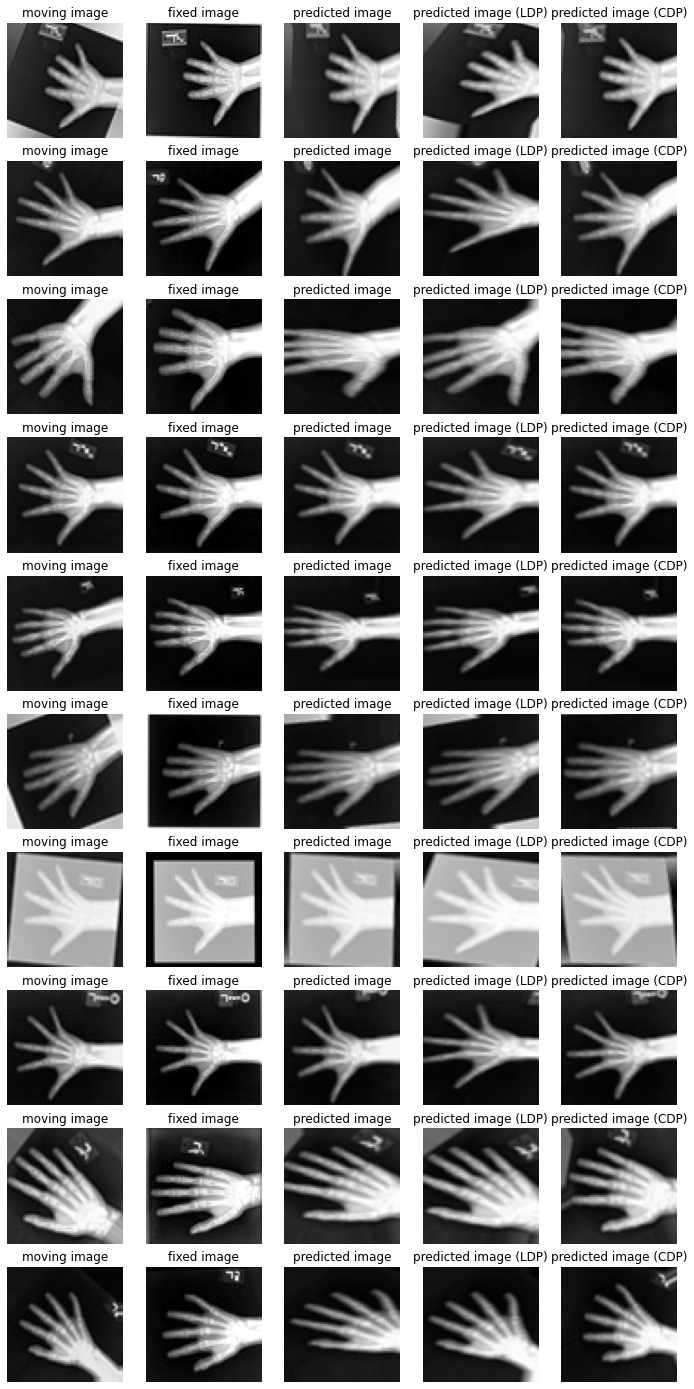

In [35]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()